In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! git clone https://github.com/MichaelGerhard/PlantDiseaseData

Cloning into 'PlantDiseaseData'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 54367 (delta 0), reused 0 (delta 0), pack-reused 54365
Receiving objects: 100% (54367/54367), 803.83 MiB | 38.67 MiB/s, done.
Checking out files: 100% (54305/54305), done.


In [4]:
#importing necessary libraries and APIs

import warnings
warnings.filterwarnings("ignore")
import os
import glob
import matplotlib.pyplot as plt
import keras

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


In [110]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [96]:
#sets paths

train_dir ="/content/PlantDiseaseData/Train"
test_dir="/content/PlantDiseaseData/Test"


In [97]:
#function that counts the number of files in a dierctory
def get_files(dir):
  if not os.path.exists(dir):
    return 0
  c=0 #initialize count with zero
  for curr_path,dirs,files in os.walk(dir):
    for d in dirs:
      c+= len(glob.glob(os.path.join(curr_path,d+"/*")))

  return c

In [98]:
train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir) 
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

38 Classes
43429 Train images
10876 Test images


In [99]:
#data generator to generate images 
train_datagen= ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, validation_split=0.2, horizontal_flip=True)
test_datagen= ImageDataGenerator(rescale=1./255)

In [100]:
img_width,img_height =224,224 #sizes are compatible with MobileNet
input_shape=(img_width,img_height,3)
batch_size =64
train_generator =train_datagen.flow_from_directory(train_dir,shuffle=True, #added shuffle here
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size,
                                                   subset='training')
validation_generator =train_datagen.flow_from_directory(train_dir,shuffle=True, #added shuffle here
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size,
                                                   subset='validation')
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)

Found 34756 images belonging to 38 classes.
Found 8673 images belonging to 38 classes.
Found 10876 images belonging to 38 classes.


In [108]:

IMG_SHAPE = (img_width, img_height, 3)

# base model is the pre-trained model MobileNet V2 (from keras library)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [120]:
#Adding the layers (model 1)

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='elu'),
  tf.keras.layers.Dropout(0.5),  #increase dropout
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(38, activation='softmax')
])

In [125]:
base_model.trainable = True


In [126]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100 #training the last 55
for layer in base_model.layers[:fine_tune_at]: # freezing the layers till the point we specified
  layer.trainable =  False

Number of layers in the base model:  155


In [127]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [128]:
model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_8 ( (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 38)                1254      
Total params: 2,627,910
Trainable params: 2,232,518
Non-trainable params: 395,392
_________________________________________________________________


In [129]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))


Number of trainable variables = 60


In [130]:
history_fine = model.fit_generator(train_generator, 
                         epochs=10,
                         validation_data=validation_generator)

Epoch 1/10
544/544 [==============================] - 460s 846ms/step - loss: 1.6898 - accuracy: 0.5920 - val_loss: 1.2773 - val_accuracy: 0.6862
Epoch 2/10
544/544 [==============================] - 462s 849ms/step - loss: 0.6320 - accuracy: 0.8457 - val_loss: 0.6346 - val_accuracy: 0.8418
Epoch 3/10
544/544 [==============================] - 470s 865ms/step - loss: 0.3848 - accuracy: 0.9023 - val_loss: 0.3915 - val_accuracy: 0.8954
Epoch 4/10
544/544 [==============================] - 473s 869ms/step - loss: 0.2753 - accuracy: 0.9270 - val_loss: 0.2758 - val_accuracy: 0.9272
Epoch 5/10
544/544 [==============================] - 476s 876ms/step - loss: 0.2154 - accuracy: 0.9423 - val_loss: 0.1984 - val_accuracy: 0.9438
Epoch 6/10
544/544 [==============================] - 484s 890ms/step - loss: 0.1701 - accuracy: 0.9539 - val_loss: 0.1660 - val_accuracy: 0.9553
Epoch 7/10
544/544 [==============================] - 495s 909ms/step - loss: 0.1471 - accuracy: 0.9591 - val_loss: 0.1380 -

In [131]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

170/170 [==============================] - 24s 141ms/step - loss: 0.1007 - accuracy: 0.9691
Test loss: 0.10069690644741058
Test accuracy: 0.9691063165664673


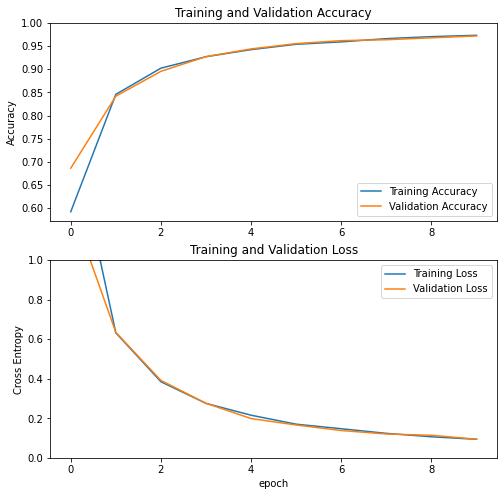

In [132]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()